# Sentiment Analysis with Machine Learning

## Import the necessary libraries

In [1]:
from typing import List, Dict
from collections import Counter
import math
from tqdm.notebook import tqdm
from scipy.special import softmax
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset_builder, load_dataset, get_dataset_split_names, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('stopwords')
nltk.download('vader_lexicon')

plt.style.use('ggplot')

[nltk_data] Downloading package punkt_tab to /Users/danc/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/danc/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /Users/danc/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /Users/danc/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/danc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/danc/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Check the features of the IMDb dataset, then load the dataset

In [2]:
ds_builder = load_dataset_builder("imdb")

# Inspect dataset features
ds_builder.info.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [3]:
# Load the IMDb dataset from Hugging Face
imdb = load_dataset("imdb")

In [4]:
# Check the dataset split names
get_dataset_split_names("imdb")

['train', 'test', 'unsupervised']

In [5]:
# Check the dataset
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [6]:
# Check the training dataset
ds_train = imdb['train']
ds_train

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [20]:
# Check the test dataset
ds_test = imdb['test']
ds_test[0]

{'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as 

In [8]:
# Concatenate the training and test datasets
ds = concatenate_datasets([ds_train, ds_test])
ds

Dataset({
    features: ['text', 'label'],
    num_rows: 50000
})

In [14]:
# Check the unsupervised dataset
ds_unsupervised = imdb['unsupervised']
ds_unsupervised

Dataset({
    features: ['text', 'label'],
    num_rows: 50000
})

## Exploratory Data Analysis (EDA)

In [31]:
# use pandas to check for missing labels
df = pd.DataFrame(ds)
num_missing_texts = df['text'].isna().sum()
print(f'Number of missing texts: {num_missing_texts}')

num_missing_labels = df['label'].isna().sum()
print(f'Number of missing labels: {num_missing_labels}')

Number of missing texts: 0
Number of missing labels: 0


In [41]:
df['length'] = df['text'].apply(lambda x: len(x.split()))
df['length'].describe()

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: length, dtype: float64

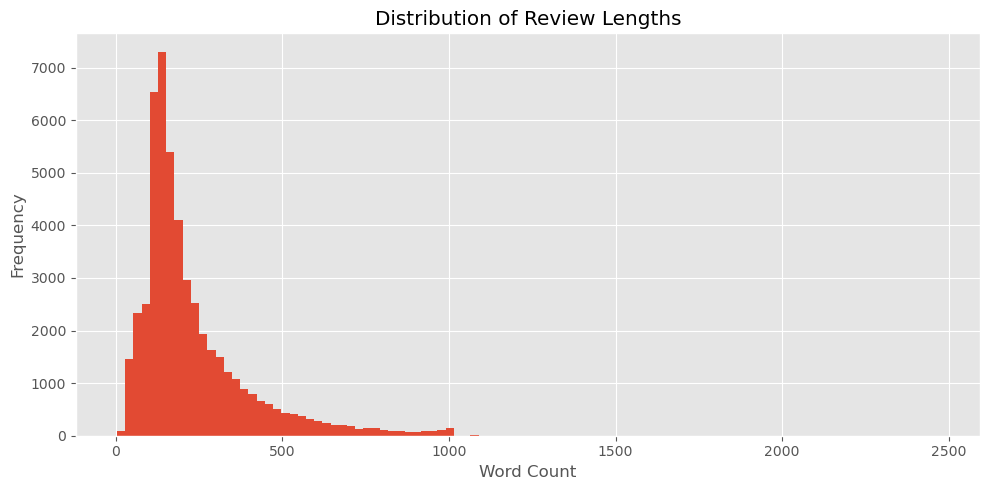

In [50]:
# check the distribution of the review lengths
df['length'].plot(kind='hist', bins=100, figsize=(10, 5), title='Distribution of Review Lengths',\
                   xlabel='Word Count', ylabel='Frequency')
plt.tight_layout()
plt.show()

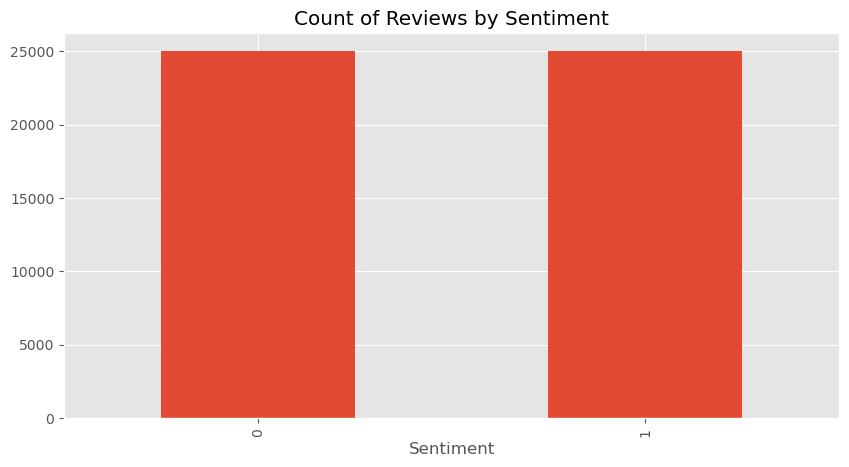

In [51]:
# check the distribution of the labels
ax = df['label'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Sentiment',
          figsize=(10, 5))
ax.set_xlabel('Sentiment')
plt.show()

## Text Preprocessing

In [ ]:
# basic NLTK preprocessing
example_text = ds_train[0]['text']
example_text
tokens = nltk.word_tokenize(example_text)
tagged = nltk.pos_tag(tokens)
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

## Model Building

### Shuffle and split the dataset

In [ ]:
# Shuffle the dataset
shuffled_dataset = ds.shuffle(seed=10)

# Split the dataset into training, validation, and test sets
ds_train = shuffled_dataset.select(range(30000))
ds_val = shuffled_dataset.select(range(30000, 40000))
ds_test = shuffled_dataset.select(range(40000, 50000))

#ds_train[0]
#ds_val[0]
ds_test

### Use the VADER model as a baseline

In [ ]:
# VADER (Valence Aware Dictionary and Sentiment Reasoner), ignoring contexts
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
sia.polarity_scores(example_text)

In [ ]:
# Run the polarity score on the entire training dataset
results_train = {}
counter = 0
for row in tqdm(ds_train, total=len(ds_train)):
    text = row['text']
    results_train[counter] = sia.polarity_scores(text)
    counter += 1

In [ ]:
vaders = pd.DataFrame(results_train).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders

In [ ]:
df_train = pd.DataFrame(ds_train)
df_train = df_train.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df_train, how='left')
vaders

In [ ]:
# plot VADER scores by sentiment label
ax = sns.barplot(data=vaders, x='label', y='compound')
ax.set_title('Compound Score by Sentiment Label')
plt.show()

In [ ]:
# plot VADER sub-scores by sentiment label
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='label', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='label', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='label', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [7]:
# Use the Roberta pretrained model for sentiment analysis
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
# Run the example text through the Roberta model and get the scores
encoded_text = tokenizer(example_text, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
scores_dict

In [18]:
# Make a function to run the Roberta model on each entry
def polarity_scores_roberta(example):
    # Tokenize with truncation
    encoded_text = tokenizer(
        example, 
        return_tensors='pt', 
        truncation=True, 
        padding=True, 
        max_length=512
    )
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    print(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [ ]:
# Test the function on the example text
polarity_scores_roberta(example_text)

In [ ]:
# Run the Roberta model on the training dataset
results_train_both = {}
counter = 0

for row in tqdm(ds_train, total=len(ds_train)):
    try:
        text = row['text']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        results_train_both[counter] = both
        counter += 1
    except RuntimeError:
        print(f'Broke for row {counter}')

In [ ]:
# try to run the model on Mac GPUs

#from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Check if MPS (Metal Performance Shaders) is available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

In [ ]:
# Load the tokenizer and model
model = model.to(device)

# Tokenize the input
inputs = tokenizer(example_text, return_tensors="pt", padding=True, truncation=True).to(device)

# Run inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Get predictions
predicted_class = torch.argmax(logits, dim=1).item()
print(example_text)
print(f"Predicted class: {predicted_class}")


In [46]:
# Make a function to run the Roberta model on the GPUs
def polarity_scores_roberta_gpu(example):
    # Tokenize with truncation
    encoded_text = tokenizer(
        example, 
        return_tensors='pt', 
        truncation=True, 
        padding=True, 
        max_length=512
    ).to(device)
    
    # Run inference
    with torch.no_grad():
        outputs = model(**encoded_text)
        #logits = outputs.logits

    # Get predictions
    scores = outputs[0][0].detach().cpu().numpy()
    scores = softmax(scores)
    #print(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [ ]:
# Test the function on the example text
polarity_scores_roberta_gpu(example_text)

In [ ]:
# Run the Roberta model on the training dataset using GPUs
results_train_both = {}
counter = 0

for row in tqdm(ds_train, total=len(ds_train)):
    try:
        text = row['text']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta_gpu(text)
        both = {**vader_result_rename, **roberta_result}
        results_train_both[counter] = both
        counter += 1
    except RuntimeError:
        print(f'Broke for row {counter}')

In [11]:
# Run the Roberta model with batch input using GPUs
def polarity_scores_roberta_gpu_batch(texts: List[str], batch_size: int = 256) -> Dict[int, Dict[str, float]]:
    """
    Analyze sentiment for a batch of texts.
        
    Args:
        texts (List[str]): List of input texts
        batch_size (int): Size of the batch to process
            
    Returns:
        Dict[int, Dict[str, float]]: Dictionary of dictionaries containing sentiment probabilities
    """

    scores_dict = {}
    num_batches = math.ceil(len(texts) / batch_size)
         
    for i in tqdm(range(num_batches)):
        # Get the batch of texts
        batch_texts = texts[i*batch_size : (i+1)*batch_size]
        
        # Tokenize with truncation
        encoded_text = tokenizer(
                 batch_texts, 
                 return_tensors='pt', 
                 truncation=True, 
                 padding=True, 
                 max_length=512
             ).to(device)
             
        # Run inference
        with torch.no_grad():
            outputs = model(**encoded_text)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
             
        # Get predictions
        for j, probs in enumerate(probabilities.cpu().numpy()):
            idx = i * batch_size + j
            scores_dict[idx] = {
                     "roberta_neg": float(probs[0]),
                     "roberta_neu": float(probs[1]),
                     "roberta_pos": float(probs[2])
                 }
         
    return scores_dict


In [ ]:
roberta_batch_result = polarity_scores_roberta_gpu_batch(ds_train['text'])
roberta_batch_result

In [ ]:
results_df = pd.DataFrame(results_train_both).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df_train, how='left')
results_df

In [ ]:
# compare the VADER and Roberta scores
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='label',
            palette='tab10')
plt.show()

In [ ]:
# sanity check the VADER and Roberta scores
results_df.query('label == 0') \
    .sort_values('roberta_pos', ascending=False)['text'].values[0]

In [ ]:
results_df.query('label == 0') \
    .sort_values('vader_pos', ascending=False)['text'].values[0]

In [ ]:
results_df.query('label == 1') \
    .sort_values('roberta_neg', ascending=False)['text'].values[0]

In [ ]:
results_df.query('label == 1') \
    .sort_values('vader_neg', ascending=False)['text'].values[0]

In [ ]:
# Use the Transformers Pipeline for sentiment analysis
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline(example_text)

In [ ]:
sent_pipeline('I love sentiment analysis!')

In [ ]:
sent_pipeline('I hate having no gpus!')

In [ ]:
sent_pipeline('What a beautiful day! All my clothes got wet!')

## Model Evaluation

## Retrieval Augmented Generation (RAG)